In [2]:
import pyro
import torch
import numpy as np
import matplotlib.pyplot as plt
import pyro.optim as optim
import pyro.distributions as dist
from torch.distributions import constraints
from pyro.infer import SVI, Trace_ELBO,TraceEnum_ELBO,config_enumerate
from tqdm import tqdm_notebook as tqdm
import seaborn as sns
from matplotlib import animation, rc
from IPython.display import HTML
import torch.nn as nn
from functools import partial
import pandas as pd
from pyro.contrib.autoguide import AutoDiagonalNormal, AutoMultivariateNormal
from pyro.infer import EmpiricalMarginal, SVI, TracePredictive
import csv

In [3]:
pyro.set_rng_seed(1)
pyro.enable_validation(True)

In [4]:
def create_vocabulary(tokenized_corpus):
    vocabulary = []
    for sentence in tokenized_corpus:
        for token in sentence:
            if token not in vocabulary:
                vocabulary.append(token)
    return vocabulary

def draw_loss_plot(losses):
    plt.plot(losses)
    plt.title("evidence lower bound (ELBO)")
    plt.xlabel("step")
    plt.ylabel("loss");

In [7]:
"""
brocolli;brocolli;basebal;brocolli;brocolli
basebal;basebal;basebal;basebal;brocolli;basebal;basebal;basebal;basebal
expert;basebal;expert;mother;brocolli;expert;expert;expert;expert;expert
brocolli;brocolli;brocolli;expert;brocolli
"""


real_documents = []
N = []
with open('test.csv', 'r', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=';')
    for row in reader:
        real_documents.append(row)
        N.append(len(row))

vocabulary = create_vocabulary(real_documents)

word2idx = {w: idx for (idx, w) in enumerate(vocabulary)}
idx2word = {idx: w for (idx, w) in enumerate(vocabulary)}

In [8]:
print(vocabulary)

['lekarz', 'weterynarz', 'pies', 'kot', 'gol', 'pilka']


In [9]:
documents = [[ word2idx[word] for word in d] for d in real_documents]
print(documents)

[[0, 1, 2, 3], [4, 5, 5, 4], [2, 3, 2, 3], [4, 5, 5, 4], [0, 1, 0, 1], [4, 5, 4, 4]]


In [10]:
num_topics = 10
num_words = len(vocabulary)
num_documents = len(documents)

In [11]:
def guide(data):
    beta_q = pyro.param("beta_q", torch.ones([num_topics, num_words])*beta, constraint=constraints.positive)

    with pyro.plate("topics", num_topics):
        phi_q = pyro.sample(f"phi", dist.Dirichlet(beta_q))

    alpha_q = pyro.param("alpha_q", torch.ones([num_documents, num_topics])*alfa, constraint=constraints.positive)


    for d in pyro.plate("documents", num_documents):
        q_theta = pyro.sample(f"theta_{d}", dist.Dirichlet(alpha_q[d, :]))

        with pyro.plate(f"words_{d}", N[d]):
            q_i = pyro.param(f"q_{d}", torch.randn([N[d], num_topics]).exp(),
                             constraint=constraints.simplex)

            pyro.sample(f"z_{d}", dist.Categorical(q_i))

def model(data):
    with pyro.plate("topics", num_topics):
        phi = pyro.sample(f"phi", dist.Dirichlet(torch.ones([num_topics, num_words])*beta))

    for d in pyro.plate("documents", num_documents):
        theta_d = pyro.sample(f"theta_{d}", dist.Dirichlet(torch.ones([1, num_topics])*alfa))

        with pyro.plate(f"words_{d}", N[d]):
            z = pyro.sample(f"z_{d}", dist.Categorical(theta_d))
            cat = dist.Categorical(phi[z, :])
            obs = pyro.sample(f"w_{d}", cat, obs=torch.tensor(data[d]))

In [12]:
alfa = 0.3
beta = 0.5

pyro.clear_param_store()
adam_params = {"lr": 0.01}
optimizer = pyro.optim.Adam({"lr": 0.002})

svi = SVI(model, config_enumerate(guide, 'parallel'), optimizer, loss=TraceEnum_ELBO(max_plate_nesting=1))

n_steps = 5000
# do gradient steps
t = tqdm(range(n_steps))
losses = []
for step in t:
    loss = svi.step(documents)
    losses.append(loss)
    t.set_postfix(loss=loss)

KeyboardInterrupt: 

In [ ]:
draw_loss_plot(losses)

In [ ]:
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))

In [ ]:
params = pyro.get_param_store()

beta_q = params["beta_q"]
phi_q = pyro.sample("phi", dist.Dirichlet(beta_q)).detach().numpy()

alpha = params["alpha_q"]
theta = pyro.sample("theta", dist.Dirichlet(alpha)).detach().numpy()
print(phi_q)
print(theta)


In [227]:
print(vocabulary)
print([[idx2word[word] for word in words[:3] ]for words in reversed(np.argsort(phi_q, axis=1))])

['brocolli', 'basebal', 'expert', 'mother']
[['mother', 'brocolli', 'expert'], ['basebal', 'expert', 'mother'], ['mother', 'basebal', 'brocolli'], ['expert', 'brocolli', 'mother']]


In [228]:
for i in range(0, len(real_documents)):
    print(f"d_{i}", real_documents[i])

d_0 ['brocolli', 'brocolli', 'basebal', 'brocolli', 'brocolli']
d_1 ['basebal', 'basebal', 'basebal', 'basebal', 'brocolli', 'basebal', 'basebal', 'basebal', 'basebal']
d_2 ['expert', 'basebal', 'expert', 'mother', 'brocolli', 'expert', 'expert', 'expert', 'expert', 'expert']
d_3 ['brocolli', 'brocolli', 'brocolli', 'expert', 'brocolli']


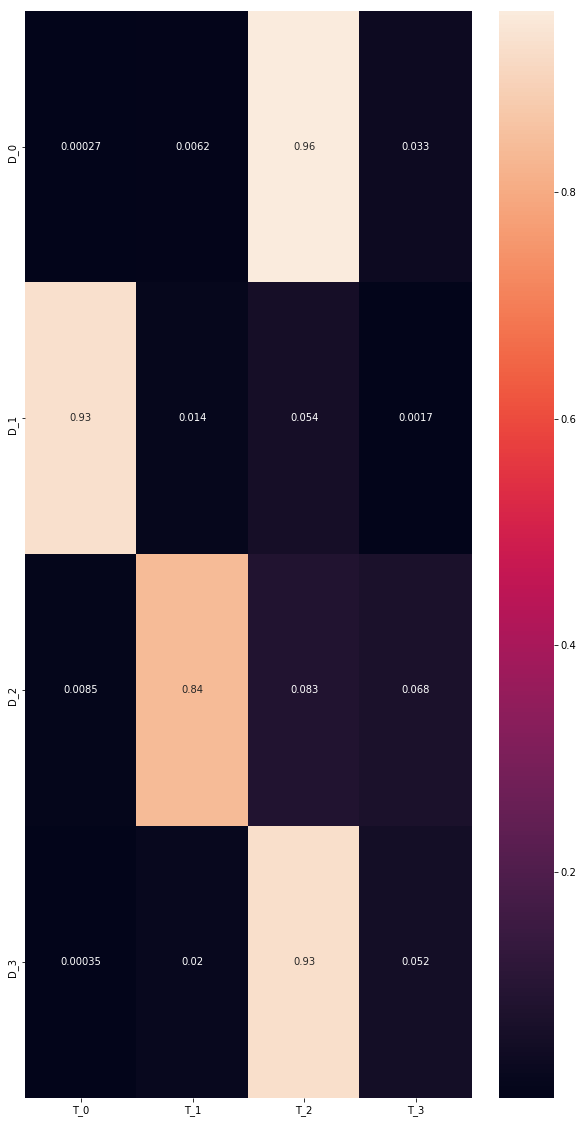

In [229]:
Index= [f'D_{i}' for i in range(0, num_documents)]
Cols = [f'T_{i}' for i in range(0, num_topics)]
df = pd.DataFrame(theta, index=Index, columns=Cols)

plt.figure(figsize=(10,20))
sns.heatmap(df, annot=True)

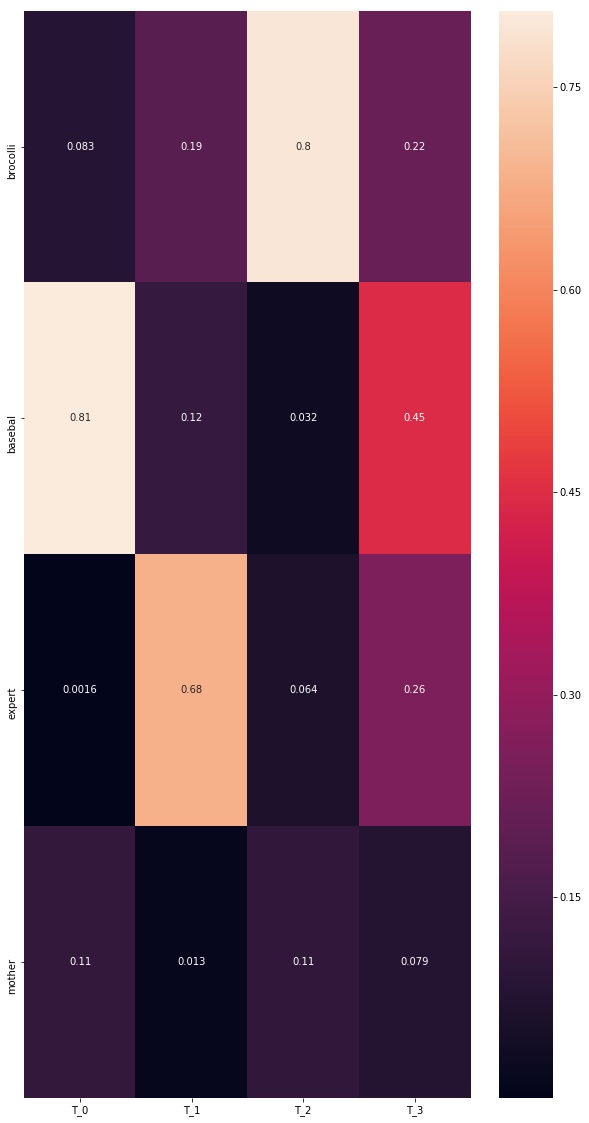

In [230]:
Index= [idx2word[i] for i in range(0, num_words)]
Cols = [f'T_{i}' for i in range(0, num_topics)]
df = pd.DataFrame(phi_q.transpose(), index=Index, columns=Cols)

plt.figure(figsize=(10,20))
sns.heatmap(df, annot=True)